# All Modules Functionality Workbook

This notebook demonstrates all steps of the workflow: fetching, transforming, training, inference, and simulation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Check local directory is 05-deployment-and-automation
!pwd

/Users/realmistic/Documents/GitHub/stock-markets-analytics-zoomcamp/05-deployment-and-automation


In [3]:
# workflow settings
FETCH_REPO = False
TRANSFORM_DATA = False
TRAIN_MODEL = False

# 1) Fetching data from API / Loading from a local storage

In [4]:
from scripts.data_repo import DataRepository

repo = DataRepository()

In [5]:
if FETCH_REPO:
  # Fetch All 3 datasets for all dates from APIs
  repo.fetch()
  # save data to a local dir
  repo.persist(data_dir='local_data/')
else:
  # OR Load from disk
  repo.load(data_dir='local_data/')  

  
# DEBUG: Separate fetching of the datasets (YFinance-Tickers, YFinance-Indexes, FRED-Macro)
# repo.fetch_tickers()
# repo.fetch_indexes()
# repo.fetch_macro()

In [6]:
# NOT WORKING YET - need to move all data transformations to Transform

# # Test fetching data with a specific min_date
# min_date = '2024-06-01'
# print(f"\nFetching data from {min_date}:")
# repo.fetch(min_date=min_date)

# repo.ticker_df.Ticker.nunique()

In [7]:
repo.ticker_df.Date.agg({'min','max','count'})

count        222187
min      1972-06-01
max      2024-06-24
Name: Date, dtype: object

In [8]:
repo.ticker_df.Ticker.nunique()

33

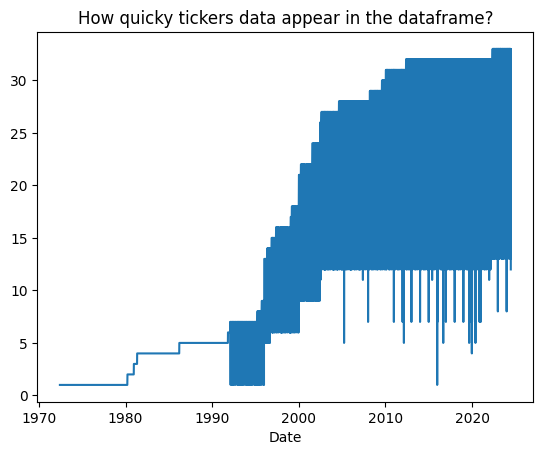

In [9]:
import matplotlib.pyplot as plt
repo.ticker_df.groupby('Date')['Open'].agg('count').plot()
plt.title('How quicky tickers data appear in the dataframe?')
plt.show()


In [10]:
repo.indexes_df.shape

(13738, 49)

In [11]:
repo.indexes_df.tail(1)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-21,0.998438,0.998427,1.016613,1.053386,1.088171,1.402954,0.995033,1.00174,0.974916,0.967542,...,1.040527,1.019861,1.039512,1.070182,0.988702,0.983965,0.970991,0.927286,1.000531,2.142805


In [12]:
repo.macro_df.tail(1)

,DGS1,DGS5,Date,Quarter,gdppot_us_yoy,gdppot_us_qoq,Month,FEDFUNDS,cpi_core_yoy,cpi_core_mom,DGS10
DATE,,,,,,,,,,,
2024-06-20,5.1,4.26,2024-06-20,2024-04-01,0.022151,0.005343,2024-06-01,5.33,0.034111,0.001631,4.25


# 2) Transform all input fields (data_repo dfs) to one dataframe

In [13]:
from scripts.transform import TransformData

transformed =  TransformData(repo = repo)

if TRANSFORM_DATA:
  transformed.transform()
  transformed.persist(data_dir='local_data/')
else:
  transformed.load(data_dir='local_data/')

In [14]:
transformed.transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183720 entries, 3490 to 5458
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns, UTC](1), datetime64[ns](2), float64(128), int32(65), int64(5), object(2)
memory usage: 240.4+ MB


In [15]:
transformed.transformed_df.tail(2)

,Open,High,Low,Close,Adj Close,Volume,ticker_type,Ticker,Year,Month_x,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5457,3604.050049,3610.0,3516.0,3535.0,3535.0,4508508.0,INDIA,LT.NS,2024,6,...,1.040527,1.019861,1.039512,1.070182,0.988702,0.983965,0.970991,0.927286,1.000531,2.142805
5458,3520.350098,3567.0,3505.0,3533.0,3533.0,1717173.0,INDIA,LT.NS,2024,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# last 3 days of the data
transformed.transformed_df.tail(3)['Date']

5456   2024-06-20 00:00:00+00:00
5457   2024-06-21 00:00:00+00:00
5458   2024-06-24 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]

# 3) Train the best model 
* Model : Random Forest(max_depth=17, n_estimators=200)

In [28]:
from scripts.train import TrainModel
import warnings

# Suppress all warnings (not recommended in production unless necessary)
warnings.filterwarnings("ignore")

trained = TrainModel(transformed=transformed)

if TRAIN_MODEL:
  trained.prepare_dataframe() # prepare dataframes
  trained.train_random_forest() # train the model
  trained.persist(data_dir='local_data/') # save the model to disk
else:
  trained.prepare_dataframe() # prepare dataframes (incl. for inference)
  trained.load(data_dir='local_data/')


Prepare the dataframe: define feature sets, add dummies, temporal split
length: X_train (124219, 240),  X_validation (29548, 240), X_test (29953, 240)
  X_train_valid = (153767, 240),  all combined: X_all (183720, 240)


In [29]:
# resulting df
trained.df_full.tail(2)

,Open,High,Low,Close,Adj Close,Volume,ticker_type,Ticker,Year,Month_x,...,Ticker_SAP,Ticker_SBIN.NS,Ticker_SIE.DE,Ticker_TCS.NS,Ticker_TTE,Ticker_V,ticker_type_EU,ticker_type_INDIA,ticker_type_US,split
5457,3604.050049,3610.0,3516.0,3535.0,3535.0,4508508.0,INDIA,LT.NS,2024,6,...,0,0,0,0,0,0,0,1,0,test
5458,3520.350098,3567.0,3505.0,3533.0,3533.0,1717173.0,INDIA,LT.NS,2024,6,...,0,0,0,0,0,0,0,1,0,test


In [30]:
trained.model

RandomForestClassifier(max_depth=17, n_estimators=200, n_jobs=-1,
                       random_state=42)

# 4) Inference

In [33]:
prediction_name='pred_rf_best'
trained.make_inference(pred_name=prediction_name)

Making inference


In [36]:
trained.df_full

,Open,High,Low,Close,Adj Close,Volume,ticker_type,Ticker,Year,Month_x,...,Ticker_SIE.DE,Ticker_TCS.NS,Ticker_TTE,Ticker_V,ticker_type_EU,ticker_type_INDIA,ticker_type_US,split,pred_rf_best,pred_rf_best_rank
3490,58.687500,59.312500,56.000000,58.281250,36.000641,53228400.0,US,MSFT,2000,1,...,0,0,0,0,0,0,1,train,0.309806,15.0
3491,56.781250,58.562500,56.125000,56.312500,34.784519,54119000.0,US,MSFT,2000,1,...,0,0,0,0,0,0,1,train,0.342859,18.0
3492,55.562500,58.187500,54.687500,56.906250,35.151291,64059600.0,US,MSFT,2000,1,...,0,0,0,0,0,0,1,train,0.325726,20.0
3493,56.093750,56.937500,54.187500,55.000000,33.973804,54976600.0,US,MSFT,2000,1,...,0,0,0,0,0,0,1,train,0.297328,21.0
3494,54.312500,56.125000,53.656250,55.718750,34.417755,62013600.0,US,MSFT,2000,1,...,0,0,0,0,0,0,1,train,0.663156,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5454,3708.000000,3710.000000,3675.000000,3689.199951,3660.425781,1936792.0,INDIA,LT.NS,2024,6,...,0,0,0,0,0,1,0,test,0.499269,11.0
5455,3690.000000,3699.000000,3575.000000,3589.949951,3561.949951,2936151.0,INDIA,LT.NS,2024,6,...,0,0,0,0,0,1,0,test,0.534216,2.0
5456,3584.949951,3613.300049,3564.600098,3594.449951,3594.449951,2618715.0,INDIA,LT.NS,2024,6,...,0,0,0,0,0,1,0,test,0.451569,21.0
5457,3604.050049,3610.000000,3516.000000,3535.000000,3535.000000,4508508.0,INDIA,LT.NS,2024,6,...,0,0,0,0,0,1,0,test,0.530128,26.0


In [40]:
COLUMNS = ['Adj Close','Ticker','Date',prediction_name, prediction_name+'_rank']
trained.df_full[trained.df_full[f'{prediction_name}_rank']==1].sort_values(by="Date").tail(10)[COLUMNS]

,Adj Close,Ticker,Date,pred_rf_best,pred_rf_best_rank
4085,274.670013,V,2024-06-11 00:00:00+00:00,0.536564,1.0
11153,191.529999,JPM,2024-06-12 00:00:00+00:00,0.534757,1.0
11154,193.660004,JPM,2024-06-13 00:00:00+00:00,0.555324,1.0
8219,64.932053,TTE,2024-06-14 00:00:00+00:00,0.571235,1.0
4089,271.170013,V,2024-06-17 00:00:00+00:00,0.564716,1.0
6817,182.809998,AMZN,2024-06-18 00:00:00+00:00,0.536077,1.0
5452,1392.349976,BHARTIARTL.NS,2024-06-19 00:00:00+00:00,0.606364,1.0
8222,66.480003,TTE,2024-06-20 00:00:00+00:00,0.491225,1.0
5425,3810.750000,TCS.NS,2024-06-21 00:00:00+00:00,0.602811,1.0
5455,1419.849976,BHARTIARTL.NS,2024-06-24 00:00:00+00:00,0.698272,1.0


In [41]:
print(trained.df_full[trained.df_full[f'{prediction_name}_rank']==1].sort_values(by="Date").tail(10)[COLUMNS])

         Adj Close         Ticker                      Date  pred_rf_best  \
4085    274.670013              V 2024-06-11 00:00:00+00:00      0.536564   
11153   191.529999            JPM 2024-06-12 00:00:00+00:00      0.534757   
11154   193.660004            JPM 2024-06-13 00:00:00+00:00      0.555324   
8219     64.932053            TTE 2024-06-14 00:00:00+00:00      0.571235   
4089    271.170013              V 2024-06-17 00:00:00+00:00      0.564716   
6817    182.809998           AMZN 2024-06-18 00:00:00+00:00      0.536077   
5452   1392.349976  BHARTIARTL.NS 2024-06-19 00:00:00+00:00      0.606364   
8222     66.480003            TTE 2024-06-20 00:00:00+00:00      0.491225   
5425   3810.750000         TCS.NS 2024-06-21 00:00:00+00:00      0.602811   
5455   1419.849976  BHARTIARTL.NS 2024-06-24 00:00:00+00:00      0.698272   

       pred_rf_best_rank  
4085                 1.0  
11153                1.0  
11154                1.0  
8219                 1.0  
4089             